## Prepare data to RandomForest ##

### Due limitations we are going to use 5 quotes of currency-pairs ###

Time and data are rather interesting from this method's perspective. There have always been attempts to use time and data in trading systems. In our models, taking into account some hidden data on the quotes dependency on the time of day and day of the week can be revealed by the classification models automatically. The only thing to do here is to convert these two variables into the categorical form. The time is to become a category with 24 levels and the date is to become a categorical variable with five levels to match the number of week days.

Besides the source predictors, we are going to create additional predictors, which, in my opinion reveal existence of trends in the source quotes. We are going to use well known indicators to create additional predictors.

The following indicators are going to be employed: 5,10 and 15 EMA; MACD(12,26,9), RSI with periods 14,21,28. On top of them we are going to use increments of quotes and moving averages. All of these conversions are to be applied to all six quotes of the currency pairs.

I will use:
    1. (3) 5, 10 and 15 EMA
    2. (3) quotes-EMAs
    3. (1) MACD(12, 26)
    4. (3) RSI with periods 5, 20, 30
    5. (4) quotes sum A+B, B+C, C+D, D+E    

In [1]:
import numpy as np
from scipy.signal import argrelextrema
from matplotlib import pyplot
import pandas as pd
%matplotlib inline

In [2]:
target_quote = 'EUR/GBP'
target_variable = target_quote

In [3]:
# sample interval is of 30 seconds
df = pd.read_pickle('cotes_21hs_29_may_16_6hours.pandas') 
del df['USD/JPY'] # delete this column of data that wont be used (tainted problems)
del df[target_variable] # TARGET VARIABLE!!
del df['time'] # wont be used for now
print(df.columns)

Index(['EUR/USD', 'GBP/USD', 'USD/CHF', 'USD/CAD'], dtype='object')


In [4]:
import pandas as pd
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

def plot_quotes(df):    
    sns.set_context("talk")
    quotes = list(df.columns) 
    f, axr = pyplot.subplots(len(quotes), sharex=True, figsize=(15,15))
    for i, ax in enumerate(axr):
        df.iloc[:,i].plot(ax=axr[i])
        axr[i].set_ylabel(quotes[i])

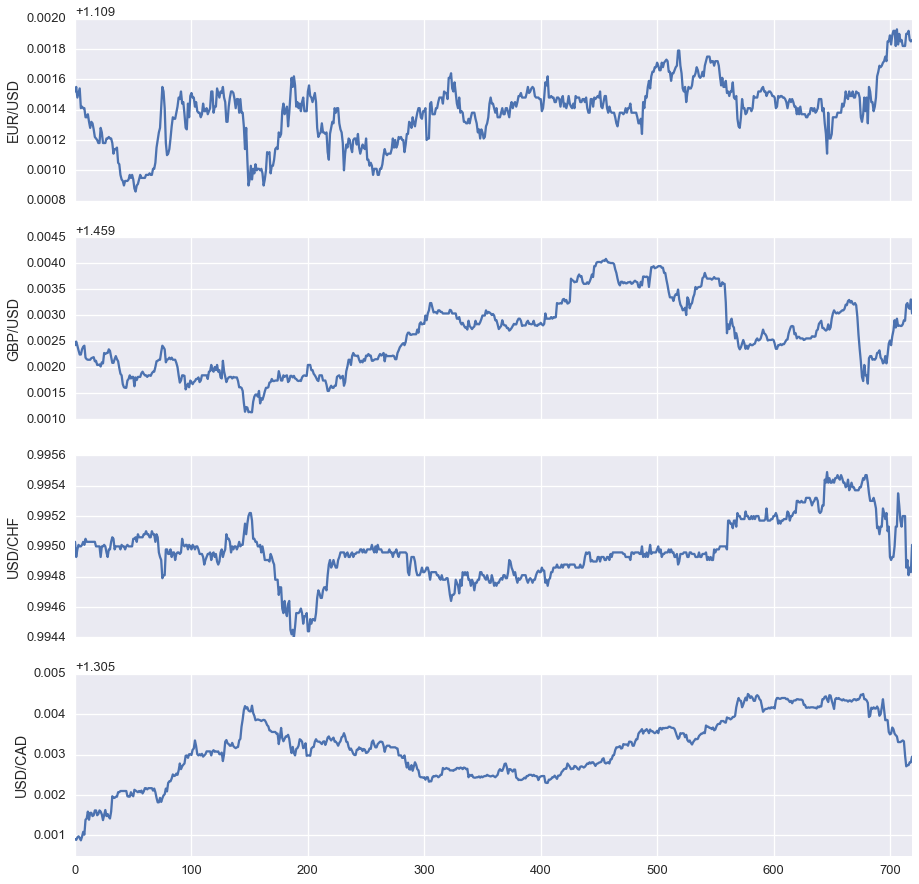

In [5]:
plot_quotes(df)

In [43]:
def MACD(y, a=26, b=12):
    return pd.ewma(y, span=12) - pd.ewma(y, span=26) #12-26

In [44]:
def RSI(y, windown=14):
    dy = y.diff()
    dy.iat[0] = dy.iat[1]
    u = dy.apply(lambda x: x if (x > 0) else 0) # uptrend 0 with where it goes down
    d = dy.apply(lambda x: -x if (x < 0) else 0) # downtred 0 with where it goes up
    # simple exponential moving average
    rs = pd.ewma(u, span=windown)/pd.ewma(d, span=windown)
    return 100 - (100/(1+rs))

In [45]:
quotes = df.columns
for quote in quotes:
    df['ema_5 '+quote] = pd.ewma(df[quote],span=5)
    df['ema_10 '+quote] = pd.ewma(df[quote],span=10)
    df['ema_15 '+quote] = pd.ewma(df[quote],span=15)
    df['dema_5 '+quote] = df[quote] - df['ema_5 '+quote]
    df['dema_10 '+quote] = df[quote] - df['ema_10 '+quote]
    df['dema_15 '+quote] = df[quote] - df['ema_15 '+quote]
    df['macd '+quote] = MACD(df[quote])
    df['rsi_5 '+quote] = RSI(df[quote], 5)
    df['rsi_20 '+quote] = RSI(df[quote], 20)
    df['rsi_30 '+quote] = RSI(df[quote], 30)
for i in range(len(quotes)-1):
    df[quotes[i]+'+'+quotes[i+1]] = df[quotes[i]]+df[quotes[i+1]]

/home/andre/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(min_periods=0,span=5,adjust=True,ignore_na=False).mean()
  app.launch_new_instance()
/home/andre/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(min_periods=0,span=10,adjust=True,ignore_na=False).mean()
/home/andre/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(min_periods=0,span=15,adjust=True,ignore_na=False).mean()
/home/andre/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(min_periods=0,span=12,a

In [46]:
# normalize 0 to 1
df = df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))

In [47]:
df.head(5)

,EUR/USD,GBP/USD,USD/CHF,USD/CAD,ema_5 EUR/USD,ema_10 EUR/USD,ema_15 EUR/USD,dema_5 EUR/USD,dema_10 EUR/USD,dema_15 EUR/USD,...,dema_5 USD/CAD,dema_10 USD/CAD,dema_15 USD/CAD,macd USD/CAD,rsi_5 USD/CAD,rsi_20 USD/CAD,rsi_30 USD/CAD,EUR/USD+GBP/USD,GBP/USD+USD/CHF,USD/CHF+USD/CAD
0,0.124169,-0.058249,0.051580,-0.617411,0.136002,0.142731,0.150453,-0.002463,-0.003767,-0.005080,...,-0.007795,-0.011715,-0.015433,-0.037770,-0.530555,-0.588530,-0.626984,-0.010826,-0.041888,-0.527556
1,0.152207,-0.034520,-0.040163,-0.622936,0.154292,0.160147,0.168066,0.027592,0.017755,0.013563,...,-0.019317,-0.020187,-0.022652,-0.038531,-0.530555,-0.588530,-0.626984,0.016952,-0.052758,-0.556612
2,0.086786,-0.061638,0.005708,-0.606361,0.126376,0.136173,0.144721,-0.078918,-0.057631,-0.051410,...,0.031621,0.016992,0.008914,-0.035582,0.204811,0.113565,0.103200,-0.024715,-0.063627,-0.529977
3,0.114823,-0.092147,0.033231,-0.598074,0.126153,0.134856,0.143128,-0.003233,-0.007816,-0.009534,...,0.040507,0.026470,0.017753,-0.032456,0.301148,0.218350,0.213369,-0.041381,-0.085366,-0.515449
4,0.142861,-0.119266,0.024057,-0.609124,0.137736,0.143177,0.150658,0.043356,0.027443,0.021305,...,-0.013529,-0.011335,-0.013761,-0.033570,-0.043445,-0.005049,-0.007395,-0.055270,-0.117975,-0.527556


### READ TARGET VARIABLE AND EVALUATE  CORRELATION ###

In [48]:
print(target_quote)

EUR/GBP


In [49]:
tgpd = pd.read_pickle('target_variable_dup.pandas')

In [50]:
df['target_variable_dup'] = pd.Series(tgpd, index=df.index)

In [51]:
df = df [ df.index != df.index[-1] ]  # remove last index cannot be used since it is a prediction

### CORRELATION BETTWEEN INDICATORS AND TARGET VARIABLE ###

In [52]:
df.head(1)

,EUR/USD,GBP/USD,USD/CHF,USD/CAD,ema_5 EUR/USD,ema_10 EUR/USD,ema_15 EUR/USD,dema_5 EUR/USD,dema_10 EUR/USD,dema_15 EUR/USD,...,dema_10 USD/CAD,dema_15 USD/CAD,macd USD/CAD,rsi_5 USD/CAD,rsi_20 USD/CAD,rsi_30 USD/CAD,EUR/USD+GBP/USD,GBP/USD+USD/CHF,USD/CHF+USD/CAD,target_variable_dup
0,0.124169,-0.058249,0.05158,-0.617411,0.136002,0.142731,0.150453,-0.002463,-0.003767,-0.00508,...,-0.011715,-0.015433,-0.03777,-0.530555,-0.58853,-0.626984,-0.010826,-0.041888,-0.527556,1.0


In [53]:
p = df.corr().ix['target_variable_dup', :-1]
p = p.apply(lambda x: np.abs(x))

In [65]:
p.sort_values(ascending=False, inplace=True)
p

ema_10 GBP/USD     0.147570
ema_15 GBP/USD     0.146874
ema_5 GBP/USD      0.145900
GBP/USD+USD/CHF    0.141607
GBP/USD            0.141589
EUR/USD+GBP/USD    0.115384
rsi_20 USD/CHF     0.083711
rsi_30 USD/CAD     0.077295
rsi_5 USD/CAD      0.076778
rsi_20 USD/CAD     0.076526
rsi_30 USD/CHF     0.075638
rsi_30 GBP/USD     0.072750
dema_15 USD/CAD    0.066181
dema_10 USD/CAD    0.065444
dema_5 USD/CAD     0.057745
rsi_5 USD/CHF      0.056442
macd USD/CAD       0.054921
macd GBP/USD       0.054428
rsi_5 EUR/USD      0.054374
rsi_20 GBP/USD     0.053335
rsi_20 EUR/USD     0.052019
dema_15 USD/CHF    0.046560
macd USD/CHF       0.042684
rsi_30 EUR/USD     0.041440
dema_10 USD/CHF    0.038136
ema_15 EUR/USD     0.036054
dema_15 EUR/USD    0.034842
dema_10 EUR/USD    0.034314
ema_15 USD/CHF     0.033552
ema_10 EUR/USD     0.031537
dema_5 EUR/USD     0.030168
ema_10 USD/CHF     0.028216
ema_5 EUR/USD      0.025345
dema_5 GBP/USD     0.022819
rsi_5 GBP/USD      0.022724
ema_5 USD/CHF      0

### We will use everything above 5% correlation ###

Correlation of indicator variables should be rule of thumb:

At least 5%.

Remove those bellow 5%

In [55]:
toremove = p.index[p < 0.05]

In [56]:
df.drop(toremove, axis='columns', inplace=True)
df.head(2)

,GBP/USD,rsi_5 EUR/USD,rsi_20 EUR/USD,ema_5 GBP/USD,ema_10 GBP/USD,ema_15 GBP/USD,macd GBP/USD,rsi_20 GBP/USD,rsi_30 GBP/USD,rsi_5 USD/CHF,...,dema_5 USD/CAD,dema_10 USD/CAD,dema_15 USD/CAD,macd USD/CAD,rsi_5 USD/CAD,rsi_20 USD/CAD,rsi_30 USD/CAD,EUR/USD+GBP/USD,GBP/USD+USD/CHF,target_variable_dup
0,-0.058249,0.493197,0.585257,-0.058964,-0.061132,-0.063162,-0.007538,0.529163,0.569762,-0.526991,...,-0.007795,-0.011715,-0.015433,-0.037770,-0.530555,-0.58853,-0.626984,-0.010826,-0.041888,1.0
1,-0.034520,0.493197,0.585257,-0.044384,-0.047091,-0.048944,-0.004611,0.529163,0.569762,-0.526991,...,-0.019317,-0.020187,-0.022652,-0.038531,-0.530555,-0.58853,-0.626984,0.016952,-0.052758,1.0


## SAVE ##

In [57]:
df.to_pickle('data_for_classification.pandas')